In [19]:
import numpy as np
import torch
import utility.dataset as dataset
from utility.preprocessing import preprocessing
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import random

In [20]:
global_models = []
local_results = []
global_results = []
tasks_data_info = []
tasks_data_idx = []

# experiment settings
type_iid=["noniid"]
task_type = ["mnist"]
num_clients = 20
class_ratio=[0.21]
active_rate = 0.2
class ARGS:
    def __init__(self):
        global num_clients
        self.num_clients = num_clients
        self.unbalance = [1.0, 1.0]  # [0]% of clients have [1]% of data
args = ARGS()
random_seed = 18796
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)



for i in range(len(task_type)):
    tasks_data_info.append(preprocessing(task_type[i], data_ratio=1.0, args=args)) # 0: trainset, 1: testset, 2: min_data_num, 3: max_data_num 4: input_size, 5: classes_size
    if type_iid[i] =='iid':
        tasks_data_idx.append(dataset.iid(dataset=tasks_data_info[i][0],
                                        min_data_num=tasks_data_info[i][2],
                                        max_data_num=tasks_data_info[i][3],
                                        num_users=num_clients)) # 0: clients_data_idx
    elif type_iid[i] =='noniid':
        tasks_data_idx.append(dataset.noniid(dataset=tasks_data_info[i][0],
                            min_data_num=tasks_data_info[i][2],
                            max_data_num=tasks_data_info[i][3],
                            class_ratio=class_ratio[i],
                            num_users=num_clients))


/Users/haoranzhang/Downloads/FL-cluster-sampling/utility/dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


In [21]:
def get_gradient(weights_this_round, weights_next_round): 
    # get gradient by subtracting weights_next_round from weights_this_round
    weight_diff = {name: (weights_this_round[name] - weights_next_round[name]).cpu() for name in weights_this_round}
    return weight_diff

def loss_sampling(m, clients):
    # sample m clients with lowest accuracy
    acc_list = []
    for i in range(len(clients)):
        acc_list.append(clients[i].get_training_accuracy())
    acc_list = np.array(acc_list)
    idx = np.argsort(acc_list)
    idx = idx[:m]
    active_clients = [clients[i] for i in idx]
    return active_clients

def cluster_sampling(active_num, clients, cluster_result):
    len_cluster = [len(cluster) for cluster in cluster_result]
    client_num  = len(clients)
    active_num_cluster = [int(active_num * len_cluster[i] / client_num) for i in range(len(len_cluster))]
    active_clients_list = []
    for i, cluster_clients in enumerate(cluster_result):
        active_clients_list.extend(loss_sampling(m=active_num_cluster[i], clients=cluster_clients))

    return active_clients_list

def flatten_params(state_dict):
    flattened_weights = np.concatenate([param.flatten() for param in state_dict])
    return flattened_weights

def cosine_similarity(state_dict1, state_dict2):
    """Compute the cosine similarity between two model state dictionaries."""
    vec1 = flatten_params(state_dict1)
    vec2 = flatten_params(state_dict2)
    # convert vec1 and vec2 to torch tensors
    vec1 = torch.tensor(vec1)
    vec2 = torch.tensor(vec2)
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    if norm1 > 0 and norm2 > 0:
        return dot_product / (norm1 * norm2)
    else:
        return 0.0


In [22]:
class MnistMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistMLP, self).__init__()
        self.in_size = 28 * 28
        self.hidden_size = 100
        self.out_size = num_classes
        self.net = nn.Sequential(
            nn.Linear(in_features=self.in_size, out_features=self.hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
        )
        for m in self.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_normal_(m.weight)

    def forward(self, batch):
        batch = batch.view(batch.size(0),-1)
        return torch.squeeze(self.net(batch))

In [23]:
class Client:
    def __init__(self, client_index, batch_size=256, tasks_index=0):
        global tasks_data_info, tasks_data_idx
        self.client_index = client_index
        self.tasks_data_info = tasks_data_info
        self.tasks_data_idx = tasks_data_idx
        self.batch_size = batch_size
        self.tasks_index = tasks_index # 0 is non-iid
        self.gradient = None
        self.set_data()
        self.model = MnistMLP()
        self.device = torch.device("cpu")
        self.training(epochs=10)
        print(f"Client {client_index}; labels {self.non_iid_labels}; accuracy {np.round(self.get_training_accuracy(), 3)}")
        self.get_trained_weights()

        local_data_num = []
        for client_idx in range(num_clients):
            local_data_num.append(len(tasks_data_idx[self.tasks_index][0][client_idx]))
        self.data_fraction = len(self.loader.dataset) / sum(local_data_num)
        


        
    def set_data(self):
        if type_iid[self.tasks_index] == 'iid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][self.client_index])  # or iid_partition depending on your choice
        elif type_iid[self.tasks_index] == 'noniid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][0][self.client_index])  # or iid_partition depending on your choice
            self.non_iid_labels = self.tasks_data_idx[self.tasks_index][1][self.client_index]
        self.loader = DataLoader(client_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
    
    
    def training(self, epochs=10):
        loader = self.loader
        self.model.to(self.device)
        previous_local_state_dict = self.model.state_dict().copy()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        client_label = tasks_data_idx[self.tasks_index][1][self.client_index]


        for _ in range(epochs):
            self.model.train()
            loss = 0
            for i, (data, target) in enumerate(loader):
                optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                label_mask = torch.zeros(tasks_data_info[self.tasks_index][5], device=output.device)
                label_mask[client_label] = 1
                output = output.masked_fill(label_mask == 0, 0)
                     
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss += loss.item()
        self.gradients = get_gradient(previous_local_state_dict, self.model.state_dict())
        return self.model
    
    def get_training_accuracy(self):
        self.model.to(self.device)
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        return correct / total
    
    def get_trained_weights(self):
        # get weights
        self.weights = []
        for param in self.model.parameters():
            self.weights.append(param.data.cpu().numpy())
        self.flattened_weights = np.concatenate([w.flatten() for w in self.weights])
        # get graidents
        self.gradients = []
        for p in self.model.parameters():
            self.gradients.append(p.grad.data.cpu().numpy())
        self.flattened_gradients = np.concatenate([g.flatten() for g in self.gradients])
        # get gradident norms
        self.gradient_norms = [np.linalg.norm(g) for g in self.gradients]

    def update_to_global_weights(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
    
    def get_local_weights(self):
        return self.model.state_dict()

In [24]:
class Cluster:
    def __init__(self, clients, num_clusters=5):
        self.clients = clients
        self.num_clusters = num_clusters
        # self.cluster()
        
    def cluster(self, method="gradient_norm"):
        #self.client_weights = np.array([c.flattened_weights for c in self.clients])
        #self.client_gradients = np.array([c.flattened_gradients for c in self.clients])
        #for c in self.clients:
        #    c.get_trained_weights()

        # try to use gradient similarity
        if method == "cosine":
            from sklearn.cluster import SpectralClustering
            gradient_similarity = np.ones((len(self.clients), len(self.clients)))
            for i in range(len(self.clients)):
                for j in range(i+1, len(self.clients)):
                    gradient_i = self.clients[i].gradients
                    gradient_j = self.clients[j].gradients
                    gradient_similarity[i, j] = cosine_similarity(gradient_i, gradient_j)
                    gradient_similarity[j, i] = gradient_similarity[i, j]
            print(gradient_similarity)
            clustering = SpectralClustering(n_clusters=self.num_clusters,
                                    affinity='precomputed',
                                    assign_labels='kmeans',
                                    random_state=0).fit(gradient_similarity)
            self.cluster_labels = clustering.labels_
        else:
            self.client_norms = np.array([c.gradient_norms for c in self.clients])
            self.data = self.client_norms
            self.pca = PCA(n_components=2)
            self.client_pca = self.pca.fit_transform(self.data)
            self.kmeans = KMeans(n_clusters=self.num_clusters)
            self.kmeans.fit(self.client_pca)
            self.cluster_labels = self.kmeans.labels_
            self.cluster_centers = self.kmeans.cluster_centers_
            # self.plot()
        
    def plot(self):
        plt.figure(figsize=(10, 10))
        for i in range(self.num_clusters):
            plt.scatter(self.client_pca[self.cluster_labels == i, 0], 
                        self.client_pca[self.cluster_labels == i, 1], 
                        label=f'Cluster {i}')
        for i, (x, y) in enumerate(self.client_pca):
            plt.annotate(f'Client {i}; labels {self.clients[i].non_iid_labels}', 
                         (x, y), 
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center')
        plt.legend()
        plt.show()
    
    def get_result(self):
        #return pd.DataFrame({"cluster_labels": self.cluster_labels, 
        #                     "client_index": [c.client_index for c in self.clients]})
        cluster_clients_list = []
        for cluster in range(self.num_clusters):
            cluster_clients_list.append([])
            # initialize cluster_clients_list

        for c in self.clients:
            c_index = c.client_index
            cluster = self.cluster_labels[c_index]
            cluster_clients_list[cluster].append(c)
        self.result = cluster_clients_list
        return self.result

In [25]:
num_clients = 10
clients = [Client(i) for i in range(num_clients)]
c = Cluster(clients)
c.cluster()
print('finish cluster')

Client 0; labels [1, 7]; accuracy 0.99
Client 1; labels [1, 3]; accuracy 0.979
Client 2; labels [1, 7]; accuracy 0.975
Client 3; labels [2, 9]; accuracy 0.984
Client 4; labels [1, 0]; accuracy 0.998
Client 5; labels [6, 3]; accuracy 0.996
Client 6; labels [8, 4]; accuracy 0.984
Client 7; labels [7, 2]; accuracy 0.984
Client 8; labels [1, 9]; accuracy 0.99
Client 9; labels [0, 6]; accuracy 0.984
finish cluster


In [26]:
class Server:
    def __init__(self, batch_size=128, tasks_index=0):
        global tasks_data_info, tasks_data_idx
        self.tasks_data_info = tasks_data_info
        self.tasks_data_idx = tasks_data_idx
        self.batch_size = batch_size
        self.tasks_index = tasks_index # 0 is non-iid
        self.test_data = self.tasks_data_info[self.tasks_index][1] # set test dataset
        self.loss_list = []
        
        self.global_model = MnistMLP()
        self.device = torch.device("cpu")
        #self.training()
        #self.get_trained_weights()
        # load global model

    def aggregation(self):
        # aggregate weights
        global_weights_state_dict = self.global_model.state_dict()
        global_keys = list(global_weights_state_dict.keys())
        for key in global_keys:
            global_weights_state_dict[key] = torch.zeros_like(global_weights_state_dict[key])

        fraction_sum = 0
        for c in self.active_clients:
            fraction_sum += c.data_fraction

        for c in self.active_clients:
            for key in global_weights_state_dict.keys():
                global_weights_state_dict[key] += c.data_fraction / fraction_sum * c.model.state_dict()[key]

        # update global model
        self.global_model.load_state_dict(global_weights_state_dict)


    def sampling(self, clients, method='random'):
        global active_rate
        active_num = int(active_rate * len(clients))
        if method == 'random':
            self.active_clients = random.sample(clients, active_num)
        elif method == 'IS':
            self.active_clients = loss_sampling(m=active_num, clients=clients)
        elif method == 'cluster':
            clusters = Cluster(clients)
            clusters.cluster()
            cluster_result = clusters.get_result()
            self.active_clients = cluster_sampling(active_num, clients, cluster_result)
    
    def get_global_loss(self):
        testloader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)
        self.global_model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        loss = 0
        with torch.no_grad():
            for i, (data, target) in enumerate(testloader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.global_model(data)
                loss += criterion(output, target)
            loss /= len(testloader)
        # print('global loss: ', loss.item())
        return loss.item()

        

    def FL_training(self, num_clients=20, rounds=10, sampling_method='random'):
        # define clients
        from tqdm import tqdm
        clients = [Client(i) for i in range(num_clients)]

        for r in tqdm(range(rounds)):
            # set local models weights to current global
            for c in clients:
                c.update_to_global_weights(self.global_model)
            # sampling with current global model
            self.sampling(clients, method=sampling_method)
            # train clients
            for c in self.active_clients:
                c.training(epochs=5)
            # aggregate weights
            self.aggregation()
            self.loss_list.append(self.get_global_loss())
    
    def plot_loss(self):
        plt.plot(self.loss_list)
        plt.show()





In [27]:
active_rate = 0.2
server_random = Server()
server_random.FL_training(sampling_method='random', rounds=150)
server_random.plot_loss()

Client 0; labels [1, 7]; accuracy 0.98
Client 1; labels [1, 3]; accuracy 0.982
Client 2; labels [1, 7]; accuracy 0.982
Client 3; labels [2, 9]; accuracy 0.988
Client 4; labels [1, 0]; accuracy 0.996
Client 5; labels [6, 3]; accuracy 1.0
Client 6; labels [8, 4]; accuracy 0.986
Client 7; labels [7, 2]; accuracy 0.98
Client 8; labels [1, 9]; accuracy 0.99
Client 9; labels [0, 6]; accuracy 0.977
Client 10; labels [3, 8]; accuracy 0.902
Client 11; labels [4, 7]; accuracy 0.98
Client 12; labels [5, 1]; accuracy 0.996
Client 13; labels [9, 2]; accuracy 0.988
Client 14; labels [0, 6]; accuracy 0.986
Client 15; labels [3, 8]; accuracy 0.961
Client 16; labels [4, 7]; accuracy 0.982
Client 17; labels [5, 1]; accuracy 0.982
Client 18; labels [9, 2]; accuracy 0.988
Client 19; labels [0, 6]; accuracy 0.98


 17%|█▋        | 25/150 [01:14<07:21,  3.53s/it]

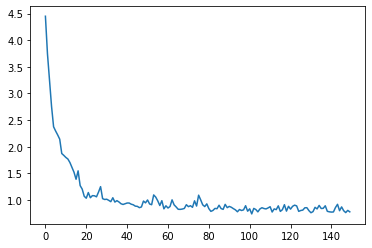

In [22]:
server_random.plot_loss()

Client 0; labels [1, 7]; accuracy 0.986
Client 1; labels [1, 3]; accuracy 0.979
Client 2; labels [1, 7]; accuracy 0.982
Client 3; labels [2, 9]; accuracy 0.99
Client 4; labels [1, 0]; accuracy 0.998
Client 5; labels [6, 3]; accuracy 0.992
Client 6; labels [8, 4]; accuracy 0.98
Client 7; labels [7, 2]; accuracy 0.979
Client 8; labels [1, 9]; accuracy 0.988
Client 9; labels [0, 6]; accuracy 0.979
Client 10; labels [3, 8]; accuracy 0.953
Client 11; labels [4, 7]; accuracy 0.986
Client 12; labels [5, 1]; accuracy 0.99
Client 13; labels [9, 2]; accuracy 0.982
Client 14; labels [0, 6]; accuracy 0.986
Client 15; labels [3, 8]; accuracy 0.961
Client 16; labels [4, 7]; accuracy 0.988
Client 17; labels [5, 1]; accuracy 0.988
Client 18; labels [9, 2]; accuracy 0.99
Client 19; labels [0, 6]; accuracy 0.99


  1%|          | 1/150 [00:04<10:26,  4.20s/it]

global loss:  8.073247909545898


  1%|▏         | 2/150 [00:08<10:39,  4.32s/it]

global loss:  5.0097527503967285


  2%|▏         | 3/150 [00:12<10:25,  4.25s/it]

global loss:  3.2135097980499268


  3%|▎         | 4/150 [00:17<10:29,  4.31s/it]

global loss:  2.298682928085327


  3%|▎         | 5/150 [00:21<10:14,  4.24s/it]

global loss:  1.9970043897628784


  4%|▍         | 6/150 [00:25<10:14,  4.27s/it]

global loss:  1.592970848083496


  5%|▍         | 7/150 [00:29<10:08,  4.26s/it]

global loss:  1.5983498096466064


  5%|▌         | 8/150 [00:34<10:06,  4.27s/it]

global loss:  1.4328824281692505


  6%|▌         | 9/150 [00:38<09:52,  4.21s/it]

global loss:  1.0968838930130005


  7%|▋         | 10/150 [00:42<09:48,  4.20s/it]

global loss:  1.1079200506210327


  7%|▋         | 11/150 [00:46<09:45,  4.21s/it]

global loss:  1.1093961000442505


  8%|▊         | 12/150 [00:50<09:41,  4.22s/it]

global loss:  1.0201911926269531


  9%|▊         | 13/150 [00:55<09:47,  4.29s/it]

global loss:  0.9511577486991882


  9%|▉         | 14/150 [00:59<09:55,  4.38s/it]

global loss:  0.9675657153129578


 10%|█         | 15/150 [01:04<09:49,  4.36s/it]

global loss:  0.9668163657188416


 11%|█         | 16/150 [01:08<09:58,  4.47s/it]

global loss:  0.95366370677948


 11%|█▏        | 17/150 [01:13<10:13,  4.62s/it]

global loss:  0.9769615530967712


 12%|█▏        | 18/150 [01:18<09:48,  4.46s/it]

global loss:  0.8893016576766968


 13%|█▎        | 19/150 [01:22<09:39,  4.42s/it]

global loss:  0.8964065313339233


 13%|█▎        | 20/150 [01:26<09:31,  4.39s/it]

global loss:  0.9259937405586243


 14%|█▍        | 21/150 [01:30<09:17,  4.32s/it]

global loss:  0.9257574677467346


 15%|█▍        | 22/150 [01:34<09:07,  4.28s/it]

global loss:  0.870146632194519


 15%|█▌        | 23/150 [01:39<08:56,  4.22s/it]

global loss:  0.8757182955741882


 16%|█▌        | 24/150 [01:43<08:45,  4.17s/it]

global loss:  0.8509498238563538


 17%|█▋        | 25/150 [01:47<08:40,  4.16s/it]

global loss:  0.8409050107002258


 17%|█▋        | 26/150 [01:51<08:34,  4.15s/it]

global loss:  0.8535673022270203


 18%|█▊        | 27/150 [01:55<08:27,  4.12s/it]

global loss:  0.8278466463088989


 19%|█▊        | 28/150 [01:59<08:20,  4.10s/it]

global loss:  0.8166224956512451


 19%|█▉        | 29/150 [02:03<08:16,  4.10s/it]

global loss:  0.8465278744697571


 20%|██        | 30/150 [02:07<08:08,  4.07s/it]

global loss:  0.8063057661056519


 21%|██        | 31/150 [02:11<08:01,  4.05s/it]

global loss:  0.8009342551231384


 21%|██▏       | 32/150 [02:15<07:56,  4.04s/it]

global loss:  0.8096228241920471


 22%|██▏       | 33/150 [02:19<07:49,  4.01s/it]

global loss:  0.8147608041763306


 23%|██▎       | 34/150 [02:23<07:50,  4.06s/it]

global loss:  0.8135939240455627


 23%|██▎       | 35/150 [02:27<07:50,  4.09s/it]

global loss:  0.8256155252456665


 24%|██▍       | 36/150 [02:31<07:41,  4.05s/it]

global loss:  0.7807336449623108


 25%|██▍       | 37/150 [02:35<07:36,  4.04s/it]

global loss:  0.7787925004959106


 25%|██▌       | 38/150 [02:39<07:33,  4.05s/it]

global loss:  0.772341251373291


 26%|██▌       | 39/150 [02:44<07:36,  4.11s/it]

global loss:  0.7774603962898254


 27%|██▋       | 40/150 [02:48<07:32,  4.11s/it]

global loss:  0.7905665636062622


 27%|██▋       | 41/150 [02:52<07:31,  4.14s/it]

global loss:  0.7456615567207336


 28%|██▊       | 42/150 [02:56<07:34,  4.21s/it]

global loss:  0.7862778902053833


 29%|██▊       | 43/150 [03:01<07:29,  4.20s/it]

global loss:  0.7685865759849548


 29%|██▉       | 44/150 [03:05<07:28,  4.23s/it]

global loss:  0.9429154396057129


 30%|███       | 45/150 [03:09<07:19,  4.18s/it]

global loss:  0.8399046659469604


 31%|███       | 46/150 [03:13<07:13,  4.16s/it]

global loss:  0.8088247776031494


 31%|███▏      | 47/150 [03:17<07:05,  4.13s/it]

global loss:  0.7675451040267944


 32%|███▏      | 48/150 [03:21<07:00,  4.12s/it]

global loss:  0.7973426580429077


 33%|███▎      | 49/150 [03:25<06:53,  4.09s/it]

global loss:  0.7963600754737854


 33%|███▎      | 50/150 [03:29<06:47,  4.08s/it]

global loss:  0.8176308274269104


 34%|███▍      | 51/150 [03:33<06:44,  4.08s/it]

global loss:  0.7909066677093506


 35%|███▍      | 52/150 [03:37<06:39,  4.08s/it]

global loss:  0.7725502848625183


 35%|███▌      | 53/150 [03:42<06:46,  4.19s/it]

global loss:  0.7857705950737


 36%|███▌      | 54/150 [03:46<06:45,  4.22s/it]

global loss:  0.7773283123970032


 37%|███▋      | 55/150 [03:50<06:42,  4.24s/it]

global loss:  0.7668699026107788


 37%|███▋      | 56/150 [03:55<06:33,  4.19s/it]

global loss:  0.761746883392334


 38%|███▊      | 57/150 [03:59<06:30,  4.20s/it]

global loss:  0.7662644982337952


 39%|███▊      | 58/150 [04:03<06:21,  4.15s/it]

global loss:  0.7634164690971375


 39%|███▉      | 59/150 [04:07<06:19,  4.17s/it]

global loss:  0.7570247650146484


 40%|████      | 60/150 [04:11<06:13,  4.15s/it]

global loss:  0.7609069347381592


 41%|████      | 61/150 [04:15<06:12,  4.19s/it]

global loss:  0.7489675879478455


 41%|████▏     | 62/150 [04:20<06:09,  4.20s/it]

global loss:  0.745478093624115


 42%|████▏     | 63/150 [04:24<06:06,  4.22s/it]

global loss:  0.7364742159843445


 43%|████▎     | 64/150 [04:28<06:03,  4.22s/it]

global loss:  0.7615169882774353


 43%|████▎     | 65/150 [04:32<05:59,  4.23s/it]

global loss:  0.7620843648910522


 44%|████▍     | 66/150 [04:36<05:52,  4.19s/it]

global loss:  0.7838169932365417


 45%|████▍     | 67/150 [04:41<05:49,  4.21s/it]

global loss:  0.7481145262718201


 45%|████▌     | 68/150 [04:45<05:39,  4.15s/it]

global loss:  0.7428260445594788


 46%|████▌     | 69/150 [04:49<05:31,  4.10s/it]

global loss:  0.751467764377594


 47%|████▋     | 70/150 [04:53<05:24,  4.05s/it]

global loss:  0.7361177802085876


 47%|████▋     | 71/150 [04:57<05:21,  4.07s/it]

global loss:  0.7892107963562012


 48%|████▊     | 72/150 [05:01<05:18,  4.08s/it]

global loss:  0.7738343477249146


 49%|████▊     | 73/150 [05:05<05:13,  4.07s/it]

global loss:  0.7603325247764587


 49%|████▉     | 74/150 [05:09<05:14,  4.13s/it]

global loss:  0.800471305847168


 50%|█████     | 75/150 [05:13<05:11,  4.16s/it]

global loss:  0.7883395552635193


 51%|█████     | 76/150 [05:18<05:06,  4.14s/it]

global loss:  0.7932830452919006


 51%|█████▏    | 77/150 [05:22<05:06,  4.20s/it]

global loss:  0.7838357090950012


 52%|█████▏    | 78/150 [05:27<05:13,  4.36s/it]

global loss:  0.7955312132835388


 53%|█████▎    | 79/150 [05:31<05:04,  4.29s/it]

global loss:  0.7639784812927246


 53%|█████▎    | 80/150 [05:35<04:59,  4.28s/it]

global loss:  0.7846370339393616


 54%|█████▍    | 81/150 [05:39<04:56,  4.30s/it]

global loss:  0.8199858665466309


 55%|█████▍    | 82/150 [05:43<04:49,  4.26s/it]

global loss:  0.7956216335296631


 55%|█████▌    | 83/150 [05:48<04:45,  4.27s/it]

global loss:  0.768500566482544


 56%|█████▌    | 84/150 [05:52<04:41,  4.27s/it]

global loss:  0.7699441313743591


 57%|█████▋    | 85/150 [05:56<04:37,  4.27s/it]

global loss:  0.7610149383544922


 57%|█████▋    | 86/150 [06:01<04:32,  4.26s/it]

global loss:  0.76760333776474


 58%|█████▊    | 87/150 [06:05<04:28,  4.26s/it]

global loss:  0.7792513966560364


 59%|█████▊    | 88/150 [06:09<04:24,  4.26s/it]

global loss:  0.7716088891029358


 59%|█████▉    | 89/150 [06:13<04:16,  4.20s/it]

global loss:  0.7492592930793762


 60%|██████    | 90/150 [06:17<04:12,  4.21s/it]

global loss:  0.7380741238594055


 61%|██████    | 91/150 [06:21<04:07,  4.19s/it]

global loss:  0.756243109703064


 61%|██████▏   | 92/150 [06:26<04:04,  4.22s/it]

global loss:  0.7556070685386658


 62%|██████▏   | 93/150 [06:30<04:01,  4.24s/it]

global loss:  0.7639699578285217


 63%|██████▎   | 94/150 [06:34<03:56,  4.23s/it]

global loss:  0.7778759002685547


 63%|██████▎   | 95/150 [06:38<03:50,  4.19s/it]

global loss:  0.7642713785171509


 64%|██████▍   | 96/150 [06:42<03:45,  4.17s/it]

global loss:  0.7953630089759827


 65%|██████▍   | 97/150 [06:47<03:42,  4.20s/it]

global loss:  0.8027268052101135


 65%|██████▌   | 98/150 [06:51<03:36,  4.17s/it]

global loss:  0.7488612532615662


 66%|██████▌   | 99/150 [06:55<03:33,  4.19s/it]

global loss:  0.7670945525169373


 67%|██████▋   | 100/150 [06:59<03:27,  4.15s/it]

global loss:  0.7761968970298767


 67%|██████▋   | 101/150 [07:03<03:22,  4.13s/it]

global loss:  0.7872139811515808


 68%|██████▊   | 102/150 [07:07<03:20,  4.17s/it]

global loss:  0.7408398389816284


 69%|██████▊   | 103/150 [07:12<03:14,  4.13s/it]

global loss:  0.7544795870780945


 69%|██████▉   | 104/150 [07:16<03:12,  4.18s/it]

global loss:  0.8076773285865784


 70%|███████   | 105/150 [07:20<03:06,  4.15s/it]

global loss:  0.7982239723205566


 71%|███████   | 106/150 [07:24<03:04,  4.20s/it]

global loss:  0.7793570756912231


 71%|███████▏  | 107/150 [07:28<02:58,  4.15s/it]

global loss:  0.8018081784248352


 72%|███████▏  | 108/150 [07:32<02:52,  4.12s/it]

global loss:  0.7784925699234009


 73%|███████▎  | 109/150 [07:36<02:48,  4.11s/it]

global loss:  0.7636172771453857


 73%|███████▎  | 110/150 [07:40<02:43,  4.09s/it]

global loss:  0.7539073824882507


 74%|███████▍  | 111/150 [07:44<02:39,  4.08s/it]

global loss:  0.7445380091667175


 75%|███████▍  | 112/150 [07:49<02:35,  4.08s/it]

global loss:  0.7783679962158203


 75%|███████▌  | 113/150 [07:53<02:30,  4.07s/it]

global loss:  0.9129621386528015


 76%|███████▌  | 114/150 [07:57<02:27,  4.10s/it]

global loss:  0.8441926836967468


 77%|███████▋  | 115/150 [08:01<02:24,  4.14s/it]

global loss:  0.8184911012649536


 77%|███████▋  | 116/150 [08:05<02:21,  4.17s/it]

global loss:  0.8332954049110413


 78%|███████▊  | 117/150 [08:09<02:17,  4.16s/it]

global loss:  0.85831618309021


 79%|███████▊  | 118/150 [08:14<02:14,  4.19s/it]

global loss:  0.7972467541694641


 79%|███████▉  | 119/150 [08:18<02:09,  4.17s/it]

global loss:  0.7990476489067078


 80%|████████  | 120/150 [08:22<02:04,  4.16s/it]

global loss:  0.8188803791999817


 81%|████████  | 121/150 [08:26<02:03,  4.25s/it]

global loss:  0.8345527052879333


 81%|████████▏ | 122/150 [08:30<01:57,  4.20s/it]

global loss:  0.838875412940979


 82%|████████▏ | 123/150 [08:35<01:52,  4.16s/it]

global loss:  0.8446353077888489


 83%|████████▎ | 124/150 [08:39<01:47,  4.15s/it]

global loss:  0.8110273480415344


 83%|████████▎ | 125/150 [08:43<01:43,  4.13s/it]

global loss:  0.8088794946670532


 84%|████████▍ | 126/150 [08:47<01:39,  4.15s/it]

global loss:  0.7926878333091736


 85%|████████▍ | 127/150 [08:51<01:34,  4.12s/it]

global loss:  0.8014445304870605


 85%|████████▌ | 128/150 [08:55<01:30,  4.12s/it]

global loss:  0.7938887476921082


 86%|████████▌ | 129/150 [08:59<01:26,  4.11s/it]

global loss:  0.8279644250869751


 87%|████████▋ | 130/150 [09:03<01:23,  4.16s/it]

global loss:  0.7913084030151367


 87%|████████▋ | 131/150 [09:08<01:18,  4.14s/it]

global loss:  0.7903922200202942


 88%|████████▊ | 132/150 [09:12<01:13,  4.11s/it]

global loss:  0.8196864128112793


 89%|████████▊ | 133/150 [09:16<01:09,  4.11s/it]

global loss:  0.8085368871688843


 89%|████████▉ | 134/150 [09:20<01:05,  4.09s/it]

global loss:  0.7918688654899597


 90%|█████████ | 135/150 [09:24<01:01,  4.08s/it]

global loss:  0.7788731455802917


 91%|█████████ | 136/150 [09:28<00:58,  4.15s/it]

global loss:  0.7719494104385376


 91%|█████████▏| 137/150 [09:32<00:53,  4.11s/it]

global loss:  0.8036072850227356


 92%|█████████▏| 138/150 [09:36<00:49,  4.17s/it]

global loss:  0.806823194026947


 93%|█████████▎| 139/150 [09:41<00:46,  4.20s/it]

global loss:  0.7722642421722412


 93%|█████████▎| 140/150 [09:45<00:41,  4.15s/it]

global loss:  0.7739134430885315


 94%|█████████▍| 141/150 [09:49<00:37,  4.13s/it]

global loss:  0.7639303803443909


 95%|█████████▍| 142/150 [09:53<00:32,  4.10s/it]

global loss:  0.7759432792663574


 95%|█████████▌| 143/150 [09:57<00:28,  4.13s/it]

global loss:  0.8109017610549927


 96%|█████████▌| 144/150 [10:01<00:24,  4.13s/it]

global loss:  0.8051080107688904


 97%|█████████▋| 145/150 [10:05<00:20,  4.11s/it]

global loss:  0.8331236243247986


 97%|█████████▋| 146/150 [10:09<00:16,  4.12s/it]

global loss:  0.8475609421730042


 98%|█████████▊| 147/150 [10:13<00:12,  4.11s/it]

global loss:  0.7996265292167664


 99%|█████████▊| 148/150 [10:18<00:08,  4.14s/it]

global loss:  0.7907260060310364


 99%|█████████▉| 149/150 [10:22<00:04,  4.16s/it]

global loss:  0.8275590538978577


100%|██████████| 150/150 [10:26<00:00,  4.18s/it]

global loss:  0.8808903694152832


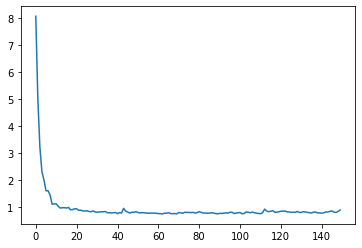

In [ ]:
active_rate = 0.2
server_IS = Server()
server_IS.FL_training(sampling_method='IS', rounds=150)
server_IS.plot_loss()

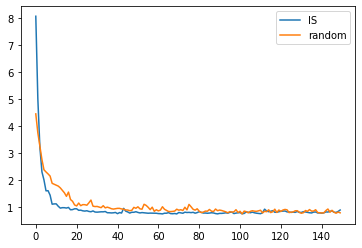

In [27]:
plt.plot(server_IS.loss_list, label='IS')
plt.plot(server_random.loss_list, label='random')
plt.legend()
plt.show()

In [ ]:
active_rate = 0.2
server_cluster = Server()
server_cluster.FL_training(sampling_method='cluster', rounds=150)
server_cluster.plot_loss()

Client 0; labels [1, 7]; accuracy 0.986
Client 1; labels [1, 3]; accuracy 0.984
Client 2; labels [1, 7]; accuracy 0.982
Client 3; labels [2, 9]; accuracy 0.98
Client 4; labels [1, 0]; accuracy 0.998
Client 5; labels [6, 3]; accuracy 0.99
Client 6; labels [8, 4]; accuracy 0.984
Client 7; labels [7, 2]; accuracy 0.984
Client 8; labels [1, 9]; accuracy 0.988
Client 9; labels [0, 6]; accuracy 0.992
Client 10; labels [3, 8]; accuracy 0.922
Client 11; labels [4, 7]; accuracy 0.984
Client 12; labels [5, 1]; accuracy 0.992
Client 13; labels [9, 2]; accuracy 0.982
Client 14; labels [0, 6]; accuracy 0.994
Client 15; labels [3, 8]; accuracy 0.957
Client 16; labels [4, 7]; accuracy 0.988
Client 17; labels [5, 1]; accuracy 0.979
Client 18; labels [9, 2]; accuracy 0.994
Client 19; labels [0, 6]; accuracy 0.984


  0%|          | 0/150 [00:00<?, ?it/s]

pca finish


  1%|          | 1/150 [00:03<08:39,  3.49s/it]

global loss:  6.325581073760986
pca finish


  1%|▏         | 2/150 [00:06<08:32,  3.46s/it]

global loss:  3.37813663482666
pca finish


  1%|▏         | 2/150 [00:08<09:58,  4.05s/it]


KeyboardInterrupt: 